# Text Generation

In this notebook, I will be generating articles out of the given dataset of weight loss articles. This will be done with the help of a character level RNN. A character level RNN treats a word as a sequence of characters. 

A helpful article to read more about the effectiveness of RNNs:
http://karpathy.github.io/2015/05/21/rnn-effectiveness/

We start by importing necessary libs and defining directory paths...

In [1]:
# For file handling...
import os,glob
from textwrap import wrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This creates sequences for us...
# Eg : windowed( [0,1,2,3,4,5] , 2) -> ([0,1],[1,2],[2,3],[3,4],[4,5])
# It returns a tuple of sequences
from boltons.iterutils import windowed
import string


#For loading data...
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.dataset import random_split


#For creating the model...
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence


# For training the model...
from torch import optim
from tqdm import tqdm,tqdm_notebook

In [2]:
DATA_DIR = os.path.join(os.getcwd(),"data")
print(DATA_DIR)

D:\PROJECTS\Github\nlp-basics\data


## Reading the data file

The data thats given is in JSON format. JSON or JavaScript Object Notation is a popular way of sharing things across the internet. Any object whose data can be serialized into a dictionary can be stored in a JSON file. This section deals with importing the data in the json file...

In [3]:
# Lets define some functions to load an clean the data...

alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789 ,;!.?"


def loadData(path,SeqLen=125):
    """
        Load data from a JSON file specified by path "path"
        SeqLen is the sequence length parameter for the RNN.
    """
    
    try:
        
        # Read the file, convert to text, take a sample of 100,
        # Convert it to string, make it lowercase and turn it into a list...
        
        # "It was a great workout" --> "it was a great workout" --> [i,t, ,w,a,s, ,a,...,t]
        texts = pd.read_json(path).text.str.lower().tolist()
        
        # [i,t, ,w,a,s, ,a,...,t] --> [[i,t],[t, ],[ ,w],...] (here SeqLen = 2)
        charsWind = [list(windowed(text,SeqLen)) for text in texts ]
        
        # a list of all characters...this will build our "vocabulary"...
        allCharsWind = [sublist for lst in charsWind for sublist in lst]
        
        # Select the printable characters out of all characters...
        goodChars = [seq for seq in tqdm_notebook(allCharsWind) 
                     if all(char in alphabets for char in seq)]
    
        return goodChars
    
    
    except OSError:
        print(f"{path} doesn't exist")
    except FileNotFoundError:
        print(f"{path} doesn't specify a JSON file.")


In [4]:
def getUniqueChars(seq):
    return {char for string in seq for char in string}

def createCharMap(seq):
    uniqueChars = getUniqueChars(seq)
    return {char : idx for idx,char in enumerate(sorted(uniqueChars))}

def encodeSeq(seq,charMap):
    return [charMap[char] for char in seq]

def encodeSequences(sequences,charMap):
    return np.array([
        encodeSeq(seq,charMap)
        for seq in tqdm_notebook(sequences)])

## Creating Dataset and Dataloaders

With our parsing functions ready, we can build our classes for datasets and loaders...

In [5]:
class TxtSequences(Dataset):
    
    def __init__(self,path,SeqLen):
        self.sequences = loadData(path,SeqLen)
        self.vocabSize = len(alphabets)
    
        self.charMap = createCharMap(self.sequences)
        self.revMap = {idx:char for char,idx in self.charMap.items()}
        self.encoded = encodeSequences(self.sequences,self.charMap)
        
    def __len__(self):
        return len(self.encoded)
    
    def __getitem__(self,i):
        
        # Our targets are inside our encoded strings
        # In this case, the last n-1 characters are predicted 
        # on the basis of first n-1 characters... 
        return self.encoded[i, : -1],self.encoded[i, 1:]

In [6]:
train_ds = TxtSequences(os.path.join(DATA_DIR,"articles.jsonl"),128)
print(train_ds.vocabSize)


68


In [7]:
BS = 1024

train_dl = DataLoader(train_ds,batch_size=BS)

## Model Definition

With our dataloaders ready, we will now define an architecture for our model. We will be using RNNs or more specifically, GRU layers. GRU or Gated Recurrent Units solve the vanishing/exploding gradient problem in Vanilla RNNs. They are similar to LSTMs in that aspect although they perform less tensor operations than them and are thus generally preferred.

In [8]:
class TxtPredictor(nn.Module):
    
    def __init__(self,vocabSize,embDims,
                 hiddenSize,numLayers,device=None):
        
        super(TxtPredictor,self).__init__()
        
        
        self.numLayers = numLayers
        self.hiddenSize = hiddenSize
        self.device=device
        
        self.encoder = nn.Embedding(vocabSize,embDims)
        self.rnn1 = nn.GRU(embDims,hiddenSize,num_layers=numLayers,batch_first=True)
        self.rnn2 = nn.GRU(hiddenSize,2*hiddenSize,num_layers=numLayers,batch_first=True)
        
        self.fc1 = nn.Linear(2*hiddenSize,hiddenSize)
        self.decoder = nn.Linear(hiddenSize,vocabSize)
    
    def initWghts(self,batchSize,m):
        wghts = torch.empty(self.numLayers,batchSize,self.hiddenSize*m)
        nn.init.kaiming_normal_(wghts,mode='fan_out')
        return wghts.to(self.device)
    
    def forward(self,inputs,hidden1,hidden2):
        encoded = self.encoder(inputs)
        output,hidden = self.rnn1(encoded.unsqueeze(1),hidden1)
        output,hidden = self.rnn2(output,hidden2)
        output = self.fc1(output.squeeze(1))
        output = self.decoder(output)
        return output,hidden
    
    def trainModel(self,epochs,train_dl,criterion,optimizer,plotLoss=True):
        self.train()
        trainLosses=[]
        
        for epoch in range(epochs):
            progressBar = tqdm_notebook(train_dl)
            losses = []
            total = 0
            
            for inputs,actual in progressBar:
                self.zero_grad()
                loss = 0
                
                inputs = inputs.long().to(device)
                actual = actual.long().to(device)
                
                batchSize = inputs.size()[0]
                hidden1 = self.initWghts(batchSize,1)
                hidden2 = self.initWghts(batchSize,2)
                
                for idx in range(inputs.size()[1]):
                    output,hidden = self(inputs[:,idx],hidden1,hidden2)
                    loss += criterion(output,actual[:,idx])
                    
                loss.backward()
                optimizer.step()
                avgLoss = loss.item()/inputs.size()[1]
                progressBar.set_description(f'Loss: {avgLoss:.3f}')
                losses.append(avgLoss)
                total += 1
                
            epochLoss = sum(losses)/total
            trainLosses.append(epochLoss)
            tqdm.write(f"Epoch : {epoch+1}\tLoss : {epochLoss:.3f}")
        
        
        if plotLoss:
            plt.plot(trainLosses)

In [9]:
device = 'cuda'
myModel = TxtPredictor(train_ds.vocabSize,100,128,1,device).to(device)
criterion = nn.CrossEntropyLoss()

print(myModel)

TxtPredictor(
  (encoder): Embedding(68, 100)
  (rnn1): GRU(100, 64, batch_first=True)
  (rnn2): GRU(64, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (decoder): Linear(in_features=64, out_features=68, bias=True)
)


Epoch : 1	Loss : 2.518


Epoch : 2	Loss : 2.515


Epoch : 3	Loss : 2.513


Epoch : 4	Loss : 2.515


Epoch : 5	Loss : 2.531


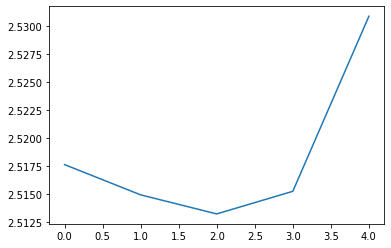

In [22]:
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, myModel.parameters()),
    lr=9e-2,)
myModel.trainModel(5,train_dl,criterion,optimizer)

In [23]:
def pretty_print(text):
    """Wrap text for nice printing."""
    to_print = ''
    for paragraph in text.split('\n'):
        to_print += '\n'.join(wrap(paragraph))
        to_print += '\n'
    print(to_print)


temperature = 1.0

In [24]:
myModel.eval()

seed = 'a'
text = ''

with torch.no_grad():
    batchSize = 1
    hidden1 = myModel.initWghts(batchSize,1)
    hidden2 = myModel.initWghts(batchSize,2)
    lastChar = train_ds.charMap[seed]
    for _ in range(1000):
        output, hidden = myModel(torch.LongTensor([lastChar]).to(device), hidden1,hidden2)
        
        distribution = output.squeeze().div(temperature).exp()
        guess = torch.multinomial(distribution, 1).item()
        
        last_char = guess
        text += train_ds.revMap[guess]
        

pretty_print(text)

rbsrtnyl llnrtnnycnnncbonrtlcno rnltnnllktonpnnnlbntnmnvlcldnnsnvtnt
yi btlnlbtlldsdrcnsb.rnnll
nlfbcncgnllrrtrnncllvblutnnandcpnsmrnrscltlmtdpnr llsintssrsnnnnts
cdpnl btllmtsynrrnnnspncbnlnln n tttlnrclsnbsb
nnrnlrnrnlnnnnnsgrntlltlrrplrnnnt nsstrnc lnnylknlltnrccrnnnpscrcnltnl
lrtngdllstrlsmrcnninsnttnoensnntntlvsbnnrsbnnstlnlnlmnnmtgltlllnanvbln
irbtnfslnrtnnnnrlmsrndnnrtnndll tnnrnfnlnrlctn lnrcnrtlnff
ccnrsasldmttnnymtllclcrnnpnlllrrnblcnp nnrdn nvote l wscnnlnnlnn
ntkrngnnntltslesrcsc irdlnnmelllnnlnn nbklrpnylensdnsy t slnltldn.pas
nsnryrnrrvnnnbltrbt cncncnncmtbmtyn rllnplscnvtlsnbntnotoprrttrnbrrtnn
ntisbbyltnllnnntnrsstnrtnsrnnrbnncpllirtrcyyntrtcrn
bnbntntlrvnnnrnndnsttnc lsnnuclnlecvlnnlftndlerlnnn
lstntfnrnnlgnsncnlltrlsmplkn lclprklctlmdlr mttnncsslninrnrsswsllb
tnonmdnttl yslssfmntnepssnltlsflnsy  nbnydnldnrsnprosrlctllnnn
grllntrmnmsgmnrnrnt wltlerbsrnltssmvltrl tndll rnlnnltcncrnnvtslr
rlntrlorlmsntl snyknrntbdttnncsnt nrrydb
rrnlyclcnnttnrcdnnlsllnyccnllststnrbntnnrn